In [1]:
import os
os.environ["PATH"] += os.pathsep + "/gpfs/apps/icl/software/CUDA/12.2.2/nvvm/bin:/gpfs/apps/icl/software/CUDA/12.2.2/bin"
LD_LIBRARY_PATH="/apps/icl/software/CUDAcompat/12.2-535.161.08/lib"
os.environ["LD_LIBRARY_PATH"]=os.pathsep+LD_LIBRARY_PATH

In [1]:
#Import all the necessary files
import datetime
from geneformer import Classifier
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification 

In [2]:
import datetime
from geneformer import Classifier

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "ethnicity_classifier_cellnexus"
output_dir = f"/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/{datestamp}"
!mkdir -p $output_dir

In [13]:
#Reading the filtered data
data=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/complete_blood/anndata/combined_anndata.h5ad")
filtered_anndata=data[data.obs['self_reported_ethnicity']!='unknown']


In [27]:
#Reading the anndata object
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/anndata/complete_anndata.h5ad")
adata.obs.cell_type.describe()
adata.obs.self_reported_ethnicity.describe()
adata.obs.dataset_id.describe()

count                                   273197
unique                                      12
top       3faad104-2ab8-4434-816d-474d8d2641db
freq                                     91199
Name: dataset_id, dtype: object

Ethnicity distribution:
self_reported_ethnicity
European                      258870
East Asian                      7760
Hispanic or Latin American      6567
Name: count, dtype: int64


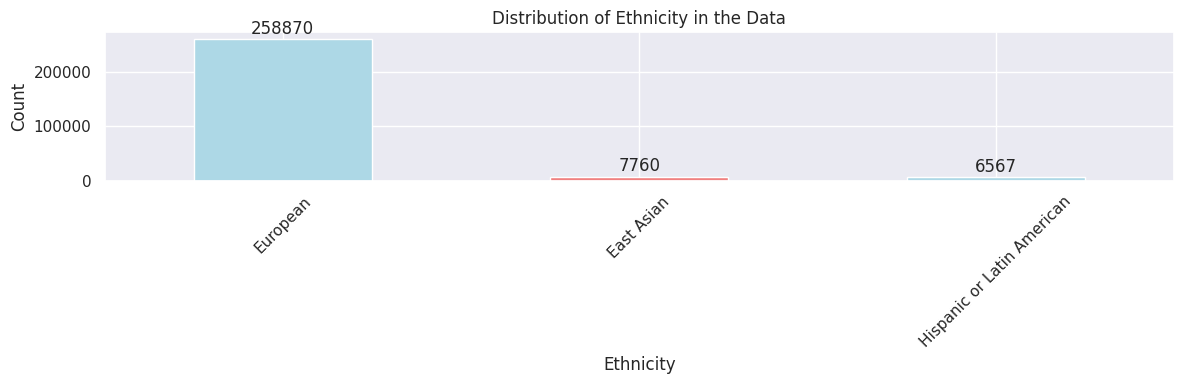

In [28]:
# Get the sex distribution
ethnicity_counts = adata.obs.self_reported_ethnicity.value_counts()
print("Ethnicity distribution:")
print(ethnicity_counts)

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 4))
ethnicity_counts.plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
ax.set_title('Distribution of Ethnicity in the Data')
ax.set_xlabel('Ethnicity')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Add count labels on top of bars
for i, v in enumerate(ethnicity_counts.values):
    ax.text(i, v + max(ethnicity_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1993606/41180142.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset_disease_counts = adata.obs.groupby(['dataset_id', 'self_reported_ethnicity']).size().unstack(fill_value=0)


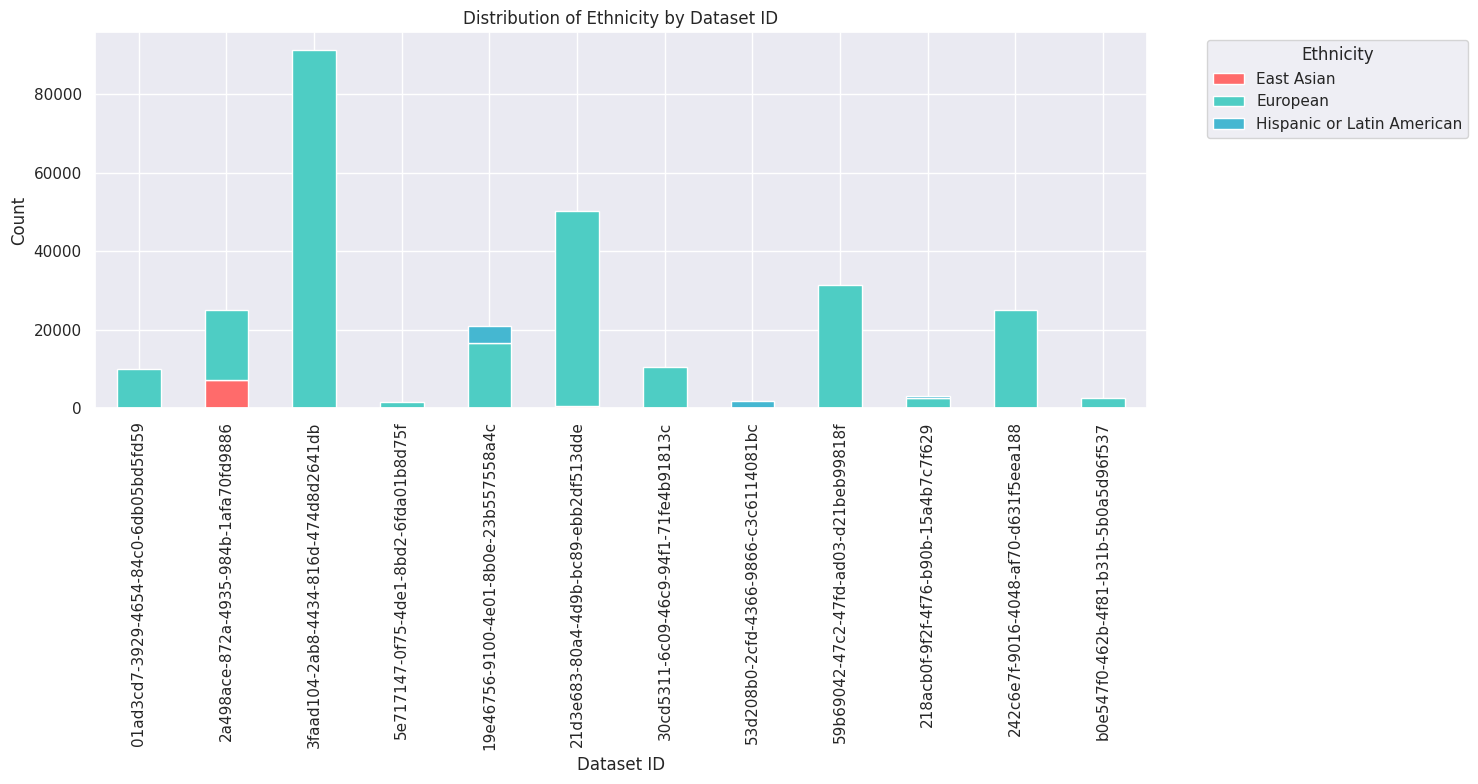

Unique dataset IDs:
['19e46756-9100-4e01-8b0e-23b557558a4c', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '242c6e7f-9016-4048-af70-d631f5eea188', '2a498ace-872a-4935-984b-1afa70fd9886', '01ad3cd7-3929-4654-84c0-6db05bd5fd59', ..., '3faad104-2ab8-4434-816d-474d8d2641db', '53d208b0-2cfd-4366-9866-c3c6114081bc', '59b69042-47c2-47fd-ad03-d21beb99818f', '5e717147-0f75-4de1-8bd2-6fda01b8d75f', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']
Length: 12
Categories (12, object): ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '2a498ace-872a-4935-984b-1afa70fd9886', '3faad104-2ab8-4434-816d-474d8d2641db', '5e717147-0f75-4de1-8bd2-6fda01b8d75f', ..., '59b69042-47c2-47fd-ad03-d21beb99818f', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '242c6e7f-9016-4048-af70-d631f5eea188', 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']


In [30]:
# Plot dataset_id vs disease
dataset_disease_counts = adata.obs.groupby(['dataset_id', 'self_reported_ethnicity']).size().unstack(fill_value=0)

# Create a stacked bar plot with distinct colors for each ethnicity
fig, ax = plt.subplots(figsize=(15, 8))
ethnicity_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
dataset_disease_counts.plot(kind='bar', stacked=True, ax=ax, color=ethnicity_colors[:len(dataset_disease_counts.columns)])
ax.set_title('Distribution of Ethnicity by Dataset ID')
ax.set_xlabel('Dataset ID')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Also show the unique dataset IDs
print("Unique dataset IDs:")
print(adata.obs.dataset_id.unique())

In [31]:
list(adata.obs.dataset_id.unique())

['19e46756-9100-4e01-8b0e-23b557558a4c',
 '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
 '242c6e7f-9016-4048-af70-d631f5eea188',
 '2a498ace-872a-4935-984b-1afa70fd9886',
 '01ad3cd7-3929-4654-84c0-6db05bd5fd59',
 '21d3e683-80a4-4d9b-bc89-ebb2df513dde',
 '30cd5311-6c09-46c9-94f1-71fe4b91813c',
 '3faad104-2ab8-4434-816d-474d8d2641db',
 '53d208b0-2cfd-4366-9866-c3c6114081bc',
 '59b69042-47c2-47fd-ad03-d21beb99818f',
 '5e717147-0f75-4de1-8bd2-6fda01b8d75f',
 'b0e547f0-462b-4f81-b31b-5b0a5d96f537']

In [32]:
!nvidia-smi

Wed Sep 10 16:47:33 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:B1:00.0 Off |                    0 |
| N/A   44C    P0    69W / 250W |   1355MiB / 40960MiB |     12%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_id=['242c6e7f-9016-4048-af70-d631f5eea188','2a498ace-872a-4935-984b-1afa70fd9886','01ad3cd7-3929-4654-84c0-6db05bd5fd59','21d3e683-80a4-4d9b-bc89-ebb2df513dde','30cd5311-6c09-46c9-94f1-71fe4b91813c','3faad104-2ab8-4434-816d-474d8d2641db','53d208b0-2cfd-4366-9866-c3c6114081bc','59b69042-47c2-47fd-ad03-d21beb99818f','5e717147-0f75-4de1-8bd2-6fda01b8d75f','b0e547f0-462b-4f81-b31b-5b0a5d96f537']
test_id=['19e46756-9100-4e01-8b0e-23b557558a4c',,'242c6e7f-9016-4048-af70-d631f5eea188']

In [33]:
# Geneformer directories for the 2048 model
gene_median_file_2048="/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/gene_median_dictionary_gc30M.pkl" 
token_dictionary_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl"
gene_mapping_file_2048= "/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/ensembl_mapping_dict_gc30M.pkl"

#Defining the tokenizer
tk = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid","self_reported_ethnicity": "self_reported_ethnicity","cell_type": "cell_type","dataset_id": "dataset_id"},
                            model_input_size = 2048,
                            special_token = False,
                            gene_median_file=gene_median_file_2048 ,
                            token_dictionary_file= token_dictionary_file_2048,
                            gene_mapping_file= gene_mapping_file_2048)

In [35]:
#directory for the anndata object
data_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/data/"
#directory for the tokenized data
token_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/complete_dataset/"

#tokenizing the data
tk.tokenize_data(data_directory=data_directory,
                 output_directory=token_dir, 
                 output_prefix="ethnicity_cell_type", 
                 file_format="h5ad")

Tokenizing /hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/data/complete_anndata.h5ad


/hpcfs/users/a1841503/myconda/envs/geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/hpcfs/users/a1841503/myconda/envs/geneformer/lib/python3.12/site-packages/geneformer/tokenizer.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/data/complete_anndata.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [3]:

filter_data_dict={"self_reported_ethnicity":["East Asian", "European", "Hispanic or Latin American"]}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "self_reported_ethnicity", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=100,
                nproc=16)

In [6]:
attr_to_balance =["self_reported_ethnicity"] 
input_data_file="/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/complete_dataset/ethnicity_cell_type.dataset"
output_directory="/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/tokenized_complete/"

# Manually balanced splits
# argument attr_to_split set to "dataset_id" and attr_to_balance set to ["Disease"]
train_id=['242c6e7f-9016-4048-af70-d631f5eea188','2a498ace-872a-4935-984b-1afa70fd9886','01ad3cd7-3929-4654-84c0-6db05bd5fd59','21d3e683-80a4-4d9b-bc89-ebb2df513dde','30cd5311-6c09-46c9-94f1-71fe4b91813c','3faad104-2ab8-4434-816d-474d8d2641db','53d208b0-2cfd-4366-9866-c3c6114081bc','59b69042-47c2-47fd-ad03-d21beb99818f','5e717147-0f75-4de1-8bd2-6fda01b8d75f','b0e547f0-462b-4f81-b31b-5b0a5d96f537']
test_id=['19e46756-9100-4e01-8b0e-23b557558a4c','242c6e7f-9016-4048-af70-d631f5eea188']
train_test_id_split_dict = {"attr_key": "dataset_id",
                            "train": train_id,
                            "test": test_id}
attr_to_balance =["self_reported_ethnicity"]

# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file=input_data_file,
                output_directory=output_dir,
                output_prefix=output_prefix,
                attr_to_balance=attr_to_balance,
                split_id_dict=train_test_id_split_dict)


In [ ]:
model_directory="/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000"


# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory=model_directory,  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          n_hyperopt_trials=10)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



2025-09-10 17:27:23,042	INFO worker.py:1841 -- Started a local Ray instance.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to

== Status ==
Current time: 2025-09-10 17:27:25 (running for 00:00:00.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/72 CPUs, 0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc   |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |       |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+-------+-----------------+---------------------+---------------

(_objective pid=2458739) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2458739) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2458739) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/18465 [00:00<?, ?it/s]/hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, i

(_objective pid=2458739) {'loss': 0.2972, 'grad_norm': 0.11399991065263748, 'learning_rate': 8.792334039577006e-06, 'epoch': 0.1}


 10%|▉         | 1846/18465 [03:29<31:29,  8.79it/s]


(_objective pid=2459716) {'loss': 0.3904, 'grad_norm': 1.2815557718276978, 'learning_rate': 1.8386986489501129e-06, 'epoch': 0.1} [repeated 3x across cluster]


 20%|█▉        | 3692/18465 [06:56<27:46,  8.87it/s]


(_objective pid=2458739) {'loss': 0.0487, 'grad_norm': 12.977611541748047, 'learning_rate': 8.336507594513911e-06, 'epoch': 0.2}
(_objective pid=2458910) {'loss': 0.0189, 'grad_norm': 0.006933850236237049, 'learning_rate': 0.00037960589156494214, 'epoch': 0.2}


 28%|██▊       | 5233/18465 [09:48<23:29,  9.39it/s] [repeated 149x across cluster]


== Status ==
Current time: 2025-09-10 17:37:25 (running for 00:10:00.18)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 30%|██▉       | 5503/18465 [10:19<24:47,  8.72it/s] [repeated 146x across cluster]


(_objective pid=2458739) {'loss': 0.0278, 'grad_norm': 0.029833709821105003, 'learning_rate': 7.45259624952632e-06, 'epoch': 0.3} [repeated 3x across cluster]


 30%|███       | 5593/18465 [10:29<25:46,  8.32it/s] [repeated 149x across cluster]


(_objective pid=2459307) {'loss': 0.1414, 'grad_norm': 0.5028825402259827, 'learning_rate': 9.225755049042669e-07, 'epoch': 0.3} [repeated 2x across cluster]


 40%|███▉      | 7343/18465 [13:47<20:23,  9.09it/s] [repeated 146x across cluster]


(_objective pid=2458739) {'loss': 0.0261, 'grad_norm': 0.035455334931612015, 'learning_rate': 6.237246358226422e-06, 'epoch': 0.4} [repeated 2x across cluster]


 40%|████      | 7392/18465 [13:56<18:44,  9.84it/s] [repeated 149x across cluster]


(_objective pid=2459307) {'loss': 0.096, 'grad_norm': 0.2469361573457718, 'learning_rate': 8.051101701743778e-07, 'epoch': 0.4} [repeated 2x across cluster]


 50%|████▉     | 9226/18465 [17:20<15:54,  9.68it/s] [repeated 149x across cluster]


(_objective pid=2458739) {'loss': 0.0221, 'grad_norm': 0.03798391669988632, 'learning_rate': 4.82334357257828e-06, 'epoch': 0.5} [repeated 2x across cluster]


 50%|█████     | 9271/18465 [17:25<17:40,  8.67it/s] [repeated 151x across cluster]


(_objective pid=2459307) {'loss': 0.0817, 'grad_norm': 1.2190898656845093, 'learning_rate': 6.876448354444886e-07, 'epoch': 0.5} [repeated 2x across cluster]


 57%|█████▋    | 10523/18465 [19:47<15:23,  8.60it/s] [repeated 147x across cluster]


== Status ==
Current time: 2025-09-10 17:47:25 (running for 00:20:00.18)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 60%|█████▉    | 11056/18465 [20:48<14:43,  8.39it/s] [repeated 149x across cluster]


(_objective pid=2458739) {'loss': 0.0185, 'grad_norm': 0.016399450600147247, 'learning_rate': 3.365483202812838e-06, 'epoch': 0.6} [repeated 2x across cluster]


 60%|█████▉    | 11076/18465 [20:51<14:44,  8.36it/s]


(_objective pid=2459307) {'loss': 0.0711, 'grad_norm': 0.13101299107074738, 'learning_rate': 5.701795007145995e-07, 'epoch': 0.6} [repeated 2x across cluster]


 70%|██████▉   | 12896/18465 [24:15<10:55,  8.49it/s] [repeated 145x across cluster]


(_objective pid=2458739) {'loss': 0.0182, 'grad_norm': 0.009004732593894005, 'learning_rate': 2.023066855904069e-06, 'epoch': 0.7} [repeated 2x across cluster]


 70%|██████▉   | 12922/18465 [24:19<10:22,  8.91it/s] [repeated 2x across cluster]


(_objective pid=2459716) {'loss': 0.0479, 'grad_norm': 0.04868986830115318, 'learning_rate': 6.132683441320461e-07, 'epoch': 0.7} [repeated 3x across cluster]


 80%|███████▉  | 14720/18465 [27:42<06:50,  9.12it/s] [repeated 147x across cluster]


(_objective pid=2458739) {'loss': 0.0167, 'grad_norm': 0.09392629563808441, 'learning_rate': 9.428735563478628e-07, 'epoch': 0.8}


 80%|████████  | 14783/18465 [27:48<07:24,  8.29it/s] [repeated 154x across cluster]


(_objective pid=2458910) {'loss': 0.0078, 'grad_norm': 0.0035858002956956625, 'learning_rate': 9.507280722369128e-05, 'epoch': 0.8}


 86%|████████▌ | 15803/18465 [29:44<05:03,  8.79it/s] [repeated 139x across cluster]


== Status ==
Current time: 2025-09-10 17:57:26 (running for 00:30:00.26)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 5/10 (1 PENDING, 4 RUNNING)
+---------------------+----------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+
| Trial name          | status   | loc                  |   learning_rate | lr_scheduler_type   |   num_train_epochs |   per_device_train_bat |    seed |   warmup_steps |   weight_decay |
|                     |          |                      |                 |                     |                    |                ch_size |         |                |                |
|---------------------+----------+--

 90%|████████▉ | 16585/18465 [31:11<03:35,  8.73it/s] [repeated 148x across cluster]


(_objective pid=2458739) {'loss': 0.0151, 'grad_norm': 0.020921671763062477, 'learning_rate': 2.4301101278539803e-07, 'epoch': 0.9} [repeated 3x across cluster]


 90%|████████▉ | 16614/18465 [31:15<03:21,  9.20it/s] [repeated 2x across cluster]


(_objective pid=2459716) {'loss': 0.0454, 'grad_norm': 5.6450958251953125, 'learning_rate': 2.0479157585935732e-07, 'epoch': 0.9} [repeated 3x across cluster]


100%|█████████▉| 18454/18465 [34:42<00:01,  8.94it/s]


(_objective pid=2458739) {'loss': 0.021, 'grad_norm': 0.01510964147746563, 'learning_rate': 1.7896668617370008e-12, 'epoch': 1.0}


100%|█████████▉| 18460/18465 [34:42<00:00,  9.29it/s]


(_objective pid=2458910) {'loss': 0.0041, 'grad_norm': 0.0009822151623666286, 'learning_rate': 2.2844577660764822e-07, 'epoch': 1.0}


100%|█████████▉| 18417/18465 [34:37<00:05,  8.30it/s]
(_objective pid=2458739) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2458739)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2458739) 
100%|█████████▉| 18419/18465 [34:37<00:05,  8.98it/s]
(_objective pid=2458739) 
100%|█████████▉| 18420/18465 [34:37<00:05,  8.77it/s]
(_objective pid=2458739) 
100%|█████████▉| 18421/18465 [34:37<00:05,  8.62it/s]
(_objective pid=2458739) 
100%|█████████▉| 18422/18465 [34:37<00:05,  8.49it/s]
(_objective pid=2458739) 
  1%|          | 16/2309 [00:00<01:25, 26.75it/s]
(_objective pid=2458910) 
100%|█████████▉| 18423/18465 [34:37<00:04,  8.44it/s]
(_objective pid=24

(_objective pid=2458739) {'eval_loss': 0.014809462241828442, 'eval_accuracy': 0.997400534334609, 'eval_macro_f1': 0.9842839913933696, 'eval_runtime': 90.4399, 'eval_samples_per_second': 306.259, 'eval_steps_per_second': 25.531, 'epoch': 1.0}
(_objective pid=2459716) {'loss': 0.0478, 'grad_norm': 0.3082532584667206, 'learning_rate': 5.531917230128505e-10, 'epoch': 1.0} [repeated 2x across cluster]


                                                     
100%|██████████| 2309/2309 [01:30<00:00, 26.33it/s]
                                                   
(_objective pid=2458910) 
 99%|█████████▉| 2290/2309 [01:29<00:00, 25.19it/s]
(_objective pid=2459307) 
 94%|█████████▍| 2181/2309 [01:25<00:05, 25.29it/s]
(_objective pid=2459716) 
 94%|█████████▎| 2163/2309 [01:25<00:05, 25.15it/s]


Trial name,epoch,eval_accuracy,eval_loss,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,objective,should_checkpoint
_objective_30ed9b54,1,0.997401,0.0148095,0.984284,90.4399,306.259,25.531,1.98168,True
_objective_384569f0,1,0.964077,0.172377,0.327237,91.1149,303.99,25.342,1.29131,True
_objective_4bec569d,1,0.990324,0.0385623,0.939404,90.8559,304.856,25.414,1.92973,True
_objective_581f14e7,1,0.985667,0.0559538,0.900016,90.6212,305.646,25.48,1.88568,True
_objective_5d2f251f,1,0.999025,0.00401321,0.994293,90.664,305.502,25.468,1.99332,True
_objective_8bdb43ca,1,0.999134,0.00361828,0.994966,88.5336,312.853,26.08,1.9941,True
_objective_acf4dfa8,1,0.997942,0.0150588,0.987642,90.3286,306.636,25.562,1.98558,True
_objective_f21a28f3,1,0.997978,0.010074,0.987925,91.125,303.956,25.339,1.9859,True
_objective_f2833361,1,0.987544,0.0499798,0.918245,90.9404,304.573,25.39,1.90579,True
_objective_fb679aac,1,0.998845,0.00545017,0.99324,89.0127,311.169,25.94,1.99208,True


(_objective pid=2458739) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25/_objective_30ed9b54_1_learning_rate=0.0000,lr_scheduler_type=cosine,num_train_epochs=1,per_device_train_batch_size=12,seed=66.5292_2025-09-10_17-27-25/checkpoint_000000)
(_objective pid=2459307) 
 95%|█████████▍| 2184/2309 [01:25<00:04, 25.83it/s]
(_objective pid=2459716) 
 94%|█████████▍| 2166/2309 [01:25<00:05, 24.53it/s]
(_objective pid=2458910) 
 99%|█████████▉| 2293/2309 [01:30<00:00, 24.70it/s]
(_objective pid=2459307) 
 95%|█████████▍| 2187/2309 [01:25<00:04, 24.98it/s]
(_objective pid=2459716) 
100%|██████████| 18465/18465 [36:15<00:00,  8.49it/s]
(_objective pid=2458910) 
 99%|█████████▉| 2296/2309 [01:30<00:00, 24.45it/s]
(_objective pid=2459307) 
 95%|█████████▍| 2190/2309 [01:25<00:04, 2

(_objective pid=2458739) {'train_runtime': 2175.1532, 'train_samples_per_second': 101.866, 'train_steps_per_second': 8.489, 'train_loss': 0.05112710343330852, 'epoch': 1.0}


(_objective pid=2458910) 
100%|█████████▉| 2299/2309 [01:30<00:00, 24.11it/s]
(_objective pid=2459307) 
 95%|█████████▍| 2193/2309 [01:26<00:04, 24.71it/s]
(_objective pid=2458910) 
100%|█████████▉| 2302/2309 [01:30<00:00, 24.08it/s]
(_objective pid=2459307) 
 95%|█████████▌| 2196/2309 [01:26<00:04, 24.38it/s]
(_objective pid=2459716) 
 94%|█████████▍| 2175/2309 [01:25<00:05, 25.01it/s]
(_objective pid=2458910) 
100%|█████████▉| 2306/2309 [01:30<00:00, 26.13it/s]
(_objective pid=2459716) 
 94%|█████████▍| 2178/2309 [01:25<00:05, 25.53it/s]
                                                     
100%|██████████| 2309/2309 [01:30<00:00, 26.13it/s]
(_objective pid=2459307) 
 95%|█████████▌| 2199/2309 [01:26<00:04, 24.41it/s]
(_objective pid=2459716) 
 94%|█████████▍| 2181/2309 [01:25<00:05, 25.17it/s]
(_objective pid=2459307) 
 95%|█████████▌| 2202/2309 [01:26<00:04, 24.08it/s]
(_objective pid=2459716) 
 95%|█████████▍| 2184/2309 [01:25<00:04, 25.71it/s]
(_objective pid=2459307) 
 95%|█████

(_objective pid=2459307) {'eval_loss': 0.055953823029994965, 'eval_accuracy': 0.9856668351505524, 'eval_macro_f1': 0.9000160583070141, 'eval_runtime': 90.6212, 'eval_samples_per_second': 305.646, 'eval_steps_per_second': 25.48, 'epoch': 1.0} [repeated 2x across cluster]
(_objective pid=2459307) {'train_runtime': 2176.0159, 'train_samples_per_second': 101.826, 'train_steps_per_second': 8.486, 'train_loss': 0.1516043894283419, 'epoch': 1.0} [repeated 2x across cluster]


(_objective pid=2459716) 
100%|█████████▉| 2302/2309 [01:30<00:00, 23.99it/s]
(_objective pid=2459716) 
100%|█████████▉| 2306/2309 [01:30<00:00, 26.03it/s]
                                                     
100%|██████████| 18465/18465 [36:13<00:00,  8.49it/s]
(_objective pid=2463642) Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
(_objective pid=2463642) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_foundation_models/models/30M_AGGsinglecell_6_emb256_SL2048_E2_B12_LR0.001_LSlinear_WU10000_Oadamw/checkpoint-75000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
(_objective pid=2463642) You should probably TRAIN this model on a down-stream task to be 

== Status ==
Current time: 2025-09-10 18:07:26 (running for 00:40:00.33)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | sta

 10%|▉         | 1843/18465 [03:29<33:20,  8.31it/s] [repeated 151x across cluster]


(_objective pid=2463642) {'loss': 0.2635, 'grad_norm': 0.05938875675201416, 'learning_rate': 1.997494484425753e-05, 'epoch': 0.1}
(_objective pid=2459716) {'eval_loss': 0.038562338799238205, 'eval_accuracy': 0.990324211134378, 'eval_macro_f1': 0.9394040906364592, 'eval_runtime': 90.8559, 'eval_samples_per_second': 304.856, 'eval_steps_per_second': 25.414, 'epoch': 1.0}
(_objective pid=2459716) {'train_runtime': 2173.8854, 'train_samples_per_second': 101.926, 'train_steps_per_second': 8.494, 'train_loss': 0.0933456448465384, 'epoch': 1.0}


 10%|▉         | 1846/18465 [03:27<30:15,  9.15it/s] [repeated 2x across cluster]


(_objective pid=2464037) {'loss': 0.0716, 'grad_norm': 0.028474004939198494, 'learning_rate': 0.00045918933884400525, 'epoch': 0.1} [repeated 3x across cluster]


 20%|█▉        | 3692/18465 [06:57<26:52,  9.16it/s]


(_objective pid=2463642) {'loss': 0.0271, 'grad_norm': 0.0236709825694561, 'learning_rate': 1.7756174269463657e-05, 'epoch': 0.2}
(_objective pid=2463795) {'loss': 0.1706, 'grad_norm': 0.16047050058841705, 'learning_rate': 0.0005599186999576183, 'epoch': 0.2}


 20%|█▉        | 3692/18465 [06:54<26:38,  9.24it/s] [repeated 2x across cluster]


(_objective pid=2464037) {'loss': 0.0363, 'grad_norm': 0.04879381135106087, 'learning_rate': 0.0004081947591757921, 'epoch': 0.2} [repeated 2x across cluster]


 30%|██▉       | 5479/18465 [10:19<25:44,  8.41it/s] [repeated 148x across cluster]


(_objective pid=2463925) {'loss': 0.0192, 'grad_norm': 4.750184535980225, 'learning_rate': 2.4047027913916145e-05, 'epoch': 0.3}


 30%|██▉       | 5533/18465 [10:25<23:16,  9.26it/s] [repeated 148x across cluster]


(_objective pid=2463642) {'loss': 0.0208, 'grad_norm': 4.2973175048828125, 'learning_rate': 1.5537403694669782e-05, 'epoch': 0.3}


 30%|███       | 5577/18465 [10:30<24:55,  8.62it/s] [repeated 149x across cluster]


(_objective pid=2464037) {'loss': 0.0301, 'grad_norm': 0.06772120296955109, 'learning_rate': 0.000357200179507579, 'epoch': 0.3} [repeated 2x across cluster]


 38%|███▊      | 7055/18465 [13:18<22:07,  8.60it/s] [repeated 155x across cluster]


== Status ==
Current time: 2025-09-10 18:17:26 (running for 00:50:00.42)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | sta

 40%|███▉      | 7327/18465 [13:48<21:03,  8.82it/s] [repeated 150x across cluster]


(_objective pid=2463925) {'loss': 0.0182, 'grad_norm': 0.045662518590688705, 'learning_rate': 2.062734712726114e-05, 'epoch': 0.4}


 40%|███▉      | 7371/18465 [13:53<20:54,  8.85it/s] [repeated 157x across cluster]


(_objective pid=2463642) {'loss': 0.0201, 'grad_norm': 0.04419784992933273, 'learning_rate': 1.331863311987591e-05, 'epoch': 0.4}


 50%|████▉     | 9173/18465 [17:16<17:53,  8.65it/s] [repeated 150x across cluster]


(_objective pid=2463925) {'loss': 0.0162, 'grad_norm': 0.005545892287045717, 'learning_rate': 1.7207666340606143e-05, 'epoch': 0.5} [repeated 3x across cluster]


 50%|████▉     | 9218/18465 [17:22<18:02,  8.55it/s] [repeated 151x across cluster]


(_objective pid=2463642) {'loss': 0.0175, 'grad_norm': 0.010374018922448158, 'learning_rate': 1.1099862545082034e-05, 'epoch': 0.5}


 50%|████▉     | 9230/18465 [17:23<18:19,  8.40it/s]


(_objective pid=2463795) {'loss': 0.1905, 'grad_norm': 0.3842727243900299, 'learning_rate': 0.0003500577400736889, 'epoch': 0.5}


 60%|█████▉    | 11005/18465 [20:44<14:47,  8.41it/s] [repeated 152x across cluster]


(_objective pid=2463925) {'loss': 0.0141, 'grad_norm': 0.005924086552113295, 'learning_rate': 1.3787985553951141e-05, 'epoch': 0.6} [repeated 2x across cluster]


 60%|█████▉    | 11052/18465 [20:50<13:28,  9.17it/s] [repeated 148x across cluster]


(_objective pid=2463642) {'loss': 0.0165, 'grad_norm': 0.007534270640462637, 'learning_rate': 8.881091970288158e-06, 'epoch': 0.6}


 60%|█████▉    | 11076/18465 [20:52<14:02,  8.77it/s]


(_objective pid=2463795) {'loss': 0.192, 'grad_norm': 1.3553314208984375, 'learning_rate': 0.00028010408677904574, 'epoch': 0.6}


 67%|██████▋   | 12358/18465 [23:17<10:43,  9.49it/s] [repeated 148x across cluster]


== Status ==
Current time: 2025-09-10 18:27:26 (running for 01:00:00.50)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | sta

 69%|██████▉   | 12804/18465 [24:08<11:29,  8.21it/s] [repeated 146x across cluster]


(_objective pid=2463925) {'loss': 0.0115, 'grad_norm': 0.004401016514748335, 'learning_rate': 1.036830476729614e-05, 'epoch': 0.7} [repeated 2x across cluster]


 70%|██████▉   | 12895/18465 [24:18<09:59,  9.30it/s] [repeated 148x across cluster]


(_objective pid=2463642) {'loss': 0.0152, 'grad_norm': 0.008819802664220333, 'learning_rate': 6.662321395494284e-06, 'epoch': 0.7}


 70%|██████▉   | 12922/18465 [24:21<10:31,  8.77it/s]


(_objective pid=2463795) {'loss': 0.1919, 'grad_norm': 0.5978267192840576, 'learning_rate': 0.00021015043348440252, 'epoch': 0.7}


 79%|███████▉  | 14657/18465 [27:36<07:26,  8.52it/s] [repeated 154x across cluster]


(_objective pid=2463925) {'loss': 0.0102, 'grad_norm': 0.0016448348760604858, 'learning_rate': 6.948623980641138e-06, 'epoch': 0.8} [repeated 2x across cluster]


 80%|███████▉  | 14746/18465 [27:46<06:34,  9.42it/s] [repeated 154x across cluster]


(_objective pid=2463642) {'loss': 0.016, 'grad_norm': 0.007620439864695072, 'learning_rate': 4.443550820700409e-06, 'epoch': 0.8}


 80%|███████▉  | 14768/18465 [27:49<06:20,  9.71it/s]


(_objective pid=2463795) {'loss': 0.1773, 'grad_norm': 0.39253368973731995, 'learning_rate': 0.00014019678018975938, 'epoch': 0.8}


 89%|████████▉ | 16464/18465 [30:59<04:00,  8.32it/s] [repeated 150x across cluster]


(_objective pid=2463925) {'loss': 0.0081, 'grad_norm': 0.004559769295156002, 'learning_rate': 3.5289431939861366e-06, 'epoch': 0.9} [repeated 2x across cluster]


 90%|████████▉ | 16596/18465 [31:14<03:41,  8.45it/s] [repeated 147x across cluster]


(_objective pid=2463642) {'loss': 0.0137, 'grad_norm': 0.33981648087501526, 'learning_rate': 2.224780245906534e-06, 'epoch': 0.9}


 90%|████████▉ | 16614/18465 [31:16<03:38,  8.48it/s]


(_objective pid=2463795) {'loss': 0.1957, 'grad_norm': 0.5695404410362244, 'learning_rate': 7.024312689511623e-05, 'epoch': 0.9}


 96%|█████████▌| 17701/18465 [33:15<01:26,  8.85it/s]


== Status ==
Current time: 2025-09-10 18:37:26 (running for 01:10:00.50)
Using FIFO scheduling algorithm.
Logical resource usage: 64.0/72 CPUs, 4.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 9/10 (1 PENDING, 4 RUNNING, 4 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | sta

 99%|█████████▉| 18315/18465 [34:24<00:16,  9.06it/s]


(_objective pid=2463925) {'loss': 0.0078, 'grad_norm': 0.014741835184395313, 'learning_rate': 1.0926240733113574e-07, 'epoch': 1.0} [repeated 2x across cluster]


 99%|█████████▉| 18313/18465 [34:30<00:17,  8.80it/s]
(_objective pid=2463925) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2463925)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2463925) 
 99%|█████████▉| 18314/18465 [34:30<00:17,  8.67it/s]
(_objective pid=2463925) 
 99%|█████████▉| 18316/18465 [34:31<00:16,  9.07it/s]
(_objective pid=2463925) 
 99%|█████████▉| 18317/18465 [34:31<00:16,  8.85it/s]
(_objective pid=2463925) 
 99%|█████████▉| 18318/18465 [34:31<00:16,  8.67it/s]
(_objective pid=2463925) 
 99%|█████████▉| 18319/18465 [34:31<00:17,  8.54it/s]
(_objective pid=2463925) 
 99%|█████████▉| 18320/18465 [34:31<00:17,  8.46it/s]
(_objective pi

(_objective pid=2463642) {'loss': 0.0134, 'grad_norm': 0.06067140772938728, 'learning_rate': 6.009671112659466e-09, 'epoch': 1.0}


100%|█████████▉| 18439/18465 [34:44<00:02,  9.52it/s]
(_objective pid=2463925) 
100%|█████████▉| 18440/18465 [34:45<00:02,  9.20it/s]
(_objective pid=2463925) 
100%|█████████▉| 18441/18465 [34:45<00:02,  8.94it/s]
(_objective pid=2463925) 
100%|█████████▉| 18442/18465 [34:45<00:02,  8.76it/s]
(_objective pid=2463925) 
100%|█████████▉| 18443/18465 [34:45<00:02,  8.89it/s]
(_objective pid=2463925) 
100%|█████████▉| 18444/18465 [34:45<00:02,  9.08it/s]
(_objective pid=2463925) 
100%|█████████▉| 18452/18465 [34:39<00:01,  9.38it/s]
(_objective pid=2463642) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2463642)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pi

(_objective pid=2464037) {'loss': 0.0177, 'grad_norm': 0.026892732828855515, 'learning_rate': 2.3812183008725547e-07, 'epoch': 1.0}


(_objective pid=2463642) 
100%|█████████▉| 18452/18465 [34:46<00:01,  8.70it/s]
(_objective pid=2463925) 
100%|█████████▉| 18461/18465 [34:40<00:00,  9.29it/s]
(_objective pid=2463642) 
(_objective pid=2463642) 
100%|█████████▉| 18454/18465 [34:46<00:01,  8.87it/s]
(_objective pid=2463925) 
100%|█████████▉| 18462/18465 [34:40<00:00,  8.99it/s]
(_objective pid=2463642) 
100%|█████████▉| 18455/18465 [34:46<00:01,  8.71it/s]
(_objective pid=2463925) 
100%|█████████▉| 18456/18465 [34:46<00:01,  8.88it/s]
(_objective pid=2463925) 
100%|█████████▉| 18464/18465 [34:41<00:00,  8.47it/s]
(_objective pid=2463642) 
100%|█████████▉| 18457/18465 [34:47<00:00,  8.72it/s]
(_objective pid=2463925) 
(_objective pid=2463642) 
100%|█████████▉| 18458/18465 [34:47<00:00,  8.94it/s]
(_objective pid=2463925) 
(_objective pid=2463642) 
(_objective pid=2463925) 
(_objective pid=2464037) 
(_objective pid=2463642) 
100%|█████████▉| 18459/18465 [34:47<00:00,  8.73it/s]
(_objective pid=2463925) 
(_objective pid=24

(_objective pid=2463925) {'eval_loss': 0.005450165830552578, 'eval_accuracy': 0.9988446819264929, 'eval_macro_f1': 0.9932402513961116, 'eval_runtime': 89.0127, 'eval_samples_per_second': 311.169, 'eval_steps_per_second': 25.94, 'epoch': 1.0}
(_objective pid=2463795) {'loss': 0.1855, 'grad_norm': 0.5300309062004089, 'learning_rate': 2.894736004730503e-07, 'epoch': 1.0}


(_objective pid=2463642) 
(_objective pid=2463925) 
                                                     A
100%|██████████| 2309/2309 [01:28<00:00, 27.28it/s]
                                                   
(_objective pid=2463795) 
(_objective pid=2463925) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25/_objective_fb679aac_7_learning_rate=0.0000,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=46._2025-09-10_18-04-00/checkpoint_000000)
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
100%|██████████| 18465/18465 [35:57<00:00,  8.56it/s]
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective p

(_objective pid=2463925) {'train_runtime': 2157.0502, 'train_samples_per_second': 102.721, 'train_steps_per_second': 8.56, 'train_loss': 0.03160939863500897, 'epoch': 1.0}


(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2463642) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2463642) 
(_objective pid=2463795) 
(_objective pid=2464037) 
(_objective pid=2463642) 
(_objective 

(_objective pid=2463642) {'eval_loss': 0.010073957033455372, 'eval_accuracy': 0.9979781933713625, 'eval_macro_f1': 0.9879254838887997, 'eval_runtime': 91.125, 'eval_samples_per_second': 303.956, 'eval_steps_per_second': 25.339, 'epoch': 1.0}


(_objective pid=2463795) 
 97%|█████████▋| 2248/2309 [01:28<00:02, 26.55it/s]
(_objective pid=2464037) 
 99%|█████████▉| 2293/2309 [01:29<00:00, 24.79it/s]
(_objective pid=2463642) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25/_objective_f21a28f3_5_learning_rate=0.0000,lr_scheduler_type=linear,num_train_epochs=1,per_device_train_batch_size=12,seed=46.9981_2025-09-10_17-27-38/checkpoint_000000)
(_objective pid=2463795) 
 97%|█████████▋| 2251/2309 [01:28<00:02, 26.00it/s]
(_objective pid=2463795) 
 98%|█████████▊| 2254/2309 [01:28<00:02, 25.18it/s]
(_objective pid=2464037) 
100%|██████████| 18465/18465 [36:17<00:00,  8.48it/s]
(_objective pid=2463795) 
 98%|█████████▊| 2257/2309 [01:29<00:02, 25.12it/s]
(_objective pid=2464037) 
100%|█████████▉| 2299/2309 [01:29<00:00, 2

(_objective pid=2463642) {'train_runtime': 2177.5766, 'train_samples_per_second': 101.753, 'train_steps_per_second': 8.48, 'train_loss': 0.04239120444017085, 'epoch': 1.0}


(_objective pid=2463795) 
 98%|█████████▊| 2260/2309 [01:29<00:01, 24.70it/s]
(_objective pid=2464037) 
100%|█████████▉| 2302/2309 [01:30<00:00, 24.16it/s]
(_objective pid=2464037) 
100%|█████████▉| 2306/2309 [01:30<00:00, 26.22it/s]
(_objective pid=2463795) 
 98%|█████████▊| 2263/2309 [01:29<00:01, 24.73it/s]
                                                     
100%|██████████| 2309/2309 [01:30<00:00, 26.22it/s]


(_objective pid=2464037) {'eval_loss': 0.015058770775794983, 'eval_accuracy': 0.9979420896815655, 'eval_macro_f1': 0.9876420738892285, 'eval_runtime': 90.3286, 'eval_samples_per_second': 306.636, 'eval_steps_per_second': 25.562, 'epoch': 1.0}


(_objective pid=2463795) 
 98%|█████████▊| 2266/2309 [01:29<00:01, 25.25it/s]
(_objective pid=2463795) 
  0%|          | 49/18465 [00:06<35:57,  8.54it/s] [repeated 37x across cluster]
(_objective pid=2463795) 
100%|██████████| 18465/18465 [36:11<00:00,  8.50it/s]
(_objective pid=2463795) 
 99%|█████████▊| 2275/2309 [01:29<00:01, 25.73it/s]
(_objective pid=2463795) 
 99%|█████████▊| 2278/2309 [01:29<00:01, 25.88it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2281/2309 [01:29<00:01, 25.06it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2284/2309 [01:30<00:00, 25.25it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2287/2309 [01:30<00:00, 24.68it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2290/2309 [01:30<00:00, 25.01it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2293/2309 [01:30<00:00, 24.55it/s]
(_objective pid=2463795) 
 99%|█████████▉| 2296/2309 [01:30<00:00, 24.32it/s]
(_objective pid=2463795) 
100%|█████████▉| 2299/2309 [01:30<00:00, 24.01it/s]
(_objective pid=2463795) 
100%|██

(_objective pid=2467625) {'loss': 0.7733, 'grad_norm': 1.7619333267211914, 'learning_rate': 1.2664479067974656e-06, 'epoch': 0.1}
(_objective pid=2463795) {'train_runtime': 2179.6639, 'train_samples_per_second': 101.656, 'train_steps_per_second': 8.471, 'train_loss': 0.17636527189419518, 'epoch': 1.0} [repeated 2x across cluster]
(_objective pid=2463795) {'eval_loss': 0.17237718403339386, 'eval_accuracy': 0.9640768286518883, 'eval_macro_f1': 0.3272366316795647, 'eval_runtime': 91.1149, 'eval_samples_per_second': 303.99, 'eval_steps_per_second': 25.342, 'epoch': 1.0}


 10%|█         | 1929/18465 [03:39<32:34,  8.46it/s] [repeated 76x across cluster]


(_objective pid=2467787) {'loss': 0.1279, 'grad_norm': 0.031141432002186775, 'learning_rate': 5.9508636926876285e-05, 'epoch': 0.1}


 20%|█▉        | 3671/18465 [06:57<28:46,  8.57it/s] [repeated 75x across cluster]


(_objective pid=2467625) {'loss': 0.1867, 'grad_norm': 0.6367433071136475, 'learning_rate': 1.1368815769371782e-06, 'epoch': 0.2}


 20%|██        | 3760/18465 [07:07<26:08,  9.37it/s] [repeated 71x across cluster]


(_objective pid=2467787) {'loss': 0.0194, 'grad_norm': 0.012535836547613144, 'learning_rate': 5.2909663236099854e-05, 'epoch': 0.2}


 20%|█▉        | 3692/18465 [06:53<25:30,  9.66it/s]


== Status ==
Current time: 2025-09-10 18:47:26 (running for 01:20:00.59)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 30%|██▉       | 5510/18465 [10:24<25:28,  8.48it/s] [repeated 75x across cluster]


(_objective pid=2467625) {'loss': 0.1231, 'grad_norm': 0.35818082094192505, 'learning_rate': 1.0073152470768903e-06, 'epoch': 0.3}


 30%|██▉       | 5529/18465 [10:19<25:02,  8.61it/s] [repeated 73x across cluster]


(_objective pid=2467787) {'loss': 0.0153, 'grad_norm': 0.00222960882820189, 'learning_rate': 4.631068954532341e-05, 'epoch': 0.3}


 40%|███▉      | 7342/18465 [13:52<21:13,  8.73it/s] [repeated 73x across cluster]


(_objective pid=2467625) {'loss': 0.0895, 'grad_norm': 2.1264891624450684, 'learning_rate': 8.777489172166026e-07, 'epoch': 0.4}


 49%|████▉     | 9047/18465 [17:05<16:16,  9.65it/s] [repeated 73x across cluster]


== Status ==
Current time: 2025-09-10 18:57:26 (running for 01:30:00.60)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 50%|████▉     | 9222/18465 [17:25<18:25,  8.36it/s] [repeated 76x across cluster]


(_objective pid=2467625) {'loss': 0.0729, 'grad_norm': 0.13104510307312012, 'learning_rate': 7.481825873563148e-07, 'epoch': 0.5} [repeated 2x across cluster]


 60%|█████▉    | 11061/18465 [20:53<14:56,  8.26it/s] [repeated 75x across cluster]


(_objective pid=2467625) {'loss': 0.0666, 'grad_norm': 0.10753867775201797, 'learning_rate': 6.186162574960271e-07, 'epoch': 0.6} [repeated 2x across cluster]


 70%|██████▉   | 12894/18465 [24:21<10:46,  8.62it/s] [repeated 74x across cluster]


(_objective pid=2467787) {'loss': 0.0047, 'grad_norm': 0.0008099162951111794, 'learning_rate': 1.9914794782217656e-05, 'epoch': 0.7} [repeated 2x across cluster]


 78%|███████▊  | 14370/18465 [27:08<07:40,  8.89it/s] [repeated 72x across cluster]


== Status ==
Current time: 2025-09-10 19:07:26 (running for 01:40:00.69)
Using FIFO scheduling algorithm.
Logical resource usage: 32.0/72 CPUs, 2.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 5d2f251f with eval_macro_f1=0.9942930590815425 and parameters={'num_train_epochs': 1, 'learning_rate': 0.00044408567142197893, 'weight_decay': 0.050964037604247156, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 1182.6778812842695, 'seed': 11.618653674521262, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 10/10 (2 RUNNING, 8 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | 

 80%|███████▉  | 14768/18465 [27:34<07:20,  8.40it/s]


(_objective pid=2467787) {'loss': 0.0046, 'grad_norm': 0.000279650412267074, 'learning_rate': 1.3315821091441223e-05, 'epoch': 0.8} [repeated 2x across cluster]


 90%|████████▉ | 16576/18465 [30:57<03:39,  8.60it/s] [repeated 76x across cluster]


(_objective pid=2467787) {'loss': 0.006, 'grad_norm': 2.729219675064087, 'learning_rate': 6.716847400664781e-06, 'epoch': 0.9} [repeated 2x across cluster]


 90%|████████▉ | 16614/18465 [31:22<03:45,  8.19it/s]


(_objective pid=2467625) {'loss': 0.0584, 'grad_norm': 7.627867221832275, 'learning_rate': 2.299172679151639e-07, 'epoch': 0.9}


100%|█████████▉| 18460/18465 [34:28<00:00,  8.43it/s]


(_objective pid=2467787) {'loss': 0.0032, 'grad_norm': 0.0009488466312177479, 'learning_rate': 1.1787370988834631e-07, 'epoch': 1.0}


100%|█████████▉| 18406/18465 [34:44<00:06,  8.97it/s]
(_objective pid=2467787) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2467787)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2467787) 
100%|█████████▉| 18407/18465 [34:44<00:06,  8.79it/s]
(_objective pid=2467787) 
100%|█████████▉| 18409/18465 [34:44<00:06,  9.02it/s]
(_objective pid=2467787) 
100%|█████████▉| 18411/18465 [34:45<00:06,  8.74it/s]
(_objective pid=2467787) 
  1%|          | 13/2309 [00:00<01:22, 27.73it/s]
(_objective pid=2467787) 
100%|█████████▉| 18413/18465 [34:45<00:05, 10.13it/s]
(_objective pid=2467787) 
100%|█████████▉| 18414/18465 [34:45<00:05,  9.61it/s]
(_objective pid=24

(_objective pid=2467625) {'loss': 0.057, 'grad_norm': 0.07027797400951385, 'learning_rate': 1.0035093805487623e-07, 'epoch': 1.0}


(_objective pid=2467787) 
100%|█████████▉| 18462/18465 [34:50<00:00,  9.23it/s]
(_objective pid=2467787) 
100%|█████████▉| 18463/18465 [34:50<00:00,  8.99it/s]
(_objective pid=2467787) 
100%|█████████▉| 18464/18465 [34:51<00:00,  8.59it/s]
(_objective pid=2467787) 
  7%|▋         | 170/2309 [00:06<01:18, 27.16it/s]
(_objective pid=2467787) 
  7%|▋         | 173/2309 [00:06<01:20, 26.66it/s]
(_objective pid=2467625) /hpcfs/users/a1841503/myconda/envs/jupyter_geneformer/lib/python3.12/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(_objective pid=2467625)   batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
(_objective pid=2467625) 
  0%|          | 0/2309 [00:00<?, ?it/s]
(_objective pid=2467787) 
  8%|▊         | 176/2309 [00:06<01:22, 25.96it/s]
(_objectiv

(_objective pid=2467787) {'eval_loss': 0.0036182766780257225, 'eval_accuracy': 0.9991335114448696, 'eval_macro_f1': 0.9949661992129131, 'eval_runtime': 88.5336, 'eval_samples_per_second': 312.853, 'eval_steps_per_second': 26.08, 'epoch': 1.0}


(_objective pid=2467787) 
                                                     A
100%|██████████| 2309/2309 [01:28<00:00, 27.41it/s]
                                                   
(_objective pid=2467625) 
(_objective pid=2467625) 
(_objective pid=2467787) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25/_objective_8bdb43ca_10_learning_rate=0.0001,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=25_2025-09-10_18-40-09/checkpoint_000000)
(_objective pid=2467625) 
(_objective pid=2467625) 
100%|██████████| 18465/18465 [35:58<00:00,  8.56it/s]
(_objective pid=2467625) 


(_objective pid=2467787) {'train_runtime': 2158.2096, 'train_samples_per_second': 102.666, 'train_steps_per_second': 8.556, 'train_loss': 0.021078619680553648, 'epoch': 1.0}


(_objective pid=2467625) 
(_objective pid=2467625) 
(_objective pid=2467625) 
(_objective pid=2467625) 
(_objective pid=2467625) 
(_objective pid=2467625) 
 91%|█████████▏| 2109/2309 [01:23<00:08, 24.39it/s]
(_objective pid=2467625) 
 91%|█████████▏| 2112/2309 [01:23<00:07, 24.77it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2115/2309 [01:23<00:07, 24.38it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2118/2309 [01:23<00:07, 24.02it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2121/2309 [01:23<00:07, 24.09it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2124/2309 [01:23<00:07, 25.14it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2127/2309 [01:23<00:07, 24.81it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2130/2309 [01:23<00:06, 25.60it/s]
(_objective pid=2467625) 
 92%|█████████▏| 2133/2309 [01:23<00:06, 26.58it/s]
(_objective pid=2467625) 
 93%|█████████▎| 2136/2309 [01:24<00:06, 26.21it/s]
(_objective pid=2467625) 
 93%|█████████▎| 2139/2309 [01:24<00:06, 25.51it/s]
(_objective 

(_objective pid=2467625) {'eval_loss': 0.049979761242866516, 'eval_accuracy': 0.9875442270200014, 'eval_macro_f1': 0.9182451732948554, 'eval_runtime': 90.9404, 'eval_samples_per_second': 304.573, 'eval_steps_per_second': 25.39, 'epoch': 1.0}


                                                     
100%|██████████| 2309/2309 [01:30<00:00, 26.09it/s]
                                                   
(_objective pid=2467625) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25/_objective_f2833361_9_learning_rate=0.0000,lr_scheduler_type=polynomial,num_train_epochs=1,per_device_train_batch_size=12,seed=11._2025-09-10_18-04-06/checkpoint_000000)
2025-09-10 19:16:38,997	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/_objective_2025-09-10_17-27-25' in 0.0054s.
2025-09-10 19:16:39,001	INFO tune.py:1041 -- Total run 

== Status ==
Current time: 2025-09-10 19:16:38 (running for 01:49:13.24)
Using FIFO scheduling algorithm.
Logical resource usage: 16.0/72 CPUs, 1.0/4 GPUs (0.0/1.0 accelerator_type:A100)
Current best trial: 8bdb43ca with eval_macro_f1=0.9949661992129131 and parameters={'num_train_epochs': 1, 'learning_rate': 6.379832730007874e-05, 'weight_decay': 0.1392899259698897, 'lr_scheduler_type': 'polynomial', 'warmup_steps': 646.8201676961772, 'seed': 25.084994128227546, 'per_device_train_batch_size': 12}
Result logdir: /mnt/tmp_local/lls_5615304/ray/session_2025-09-10_17-27-19_346995_2453490/artifacts/2025-09-10_17-27-25/_objective_2025-09-10_17-27-25/driver_artifacts
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+----------------------+-----------------+---------------------+--------------------+------------------------+---------+----------------+----------------+-------------+-----------------+-----------------+
| Trial name          | status     | loc           

100%|██████████| 18465/18465 [36:22<00:00,  8.46it/s]


(_objective pid=2467625) {'train_runtime': 2182.5298, 'train_samples_per_second': 101.522, 'train_steps_per_second': 8.46, 'train_loss': 0.15485855988006167, 'epoch': 1.0}


In [8]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "self_reported_ethnicity", "states": "all"},
                forward_batch_size=50,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [10]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory="/hpcfs/users/a1841503/trained_classifiers/etnicity_classifier_v1_cellnexus_blood/250910172516/250910_geneformer_cellClassifier_ethnicity_classifier_cellnexus/ksplit1/run-fb679aac/checkpoint-18465",
        id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/{output_prefix}_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/919 [00:00<?, ?it/s]

In [11]:
all_metrics_test["conf_matrix"]

,Hispanic or Latin American,East Asian,European
Hispanic or Latin American,0,1195,3124
East Asian,0,0,0
European,0,3968,37647


<Figure size 1000x1000 with 0 Axes>

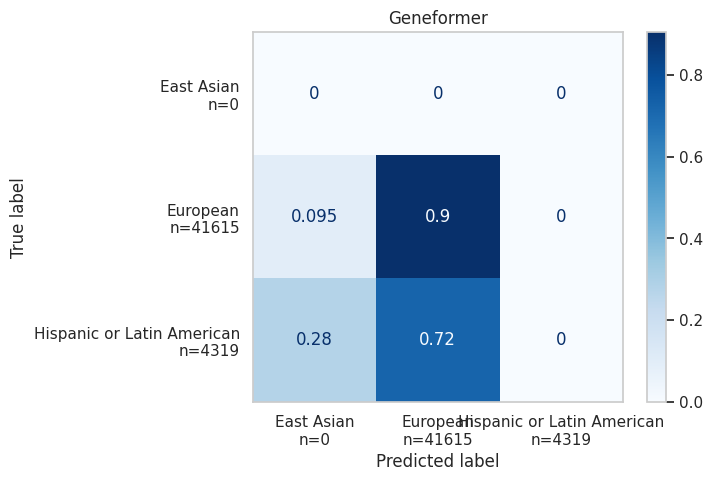

In [16]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        custom_class_order=["East Asian", "European","Hispanic or Latin American"],
)

<Figure size 1500x1500 with 0 Axes>

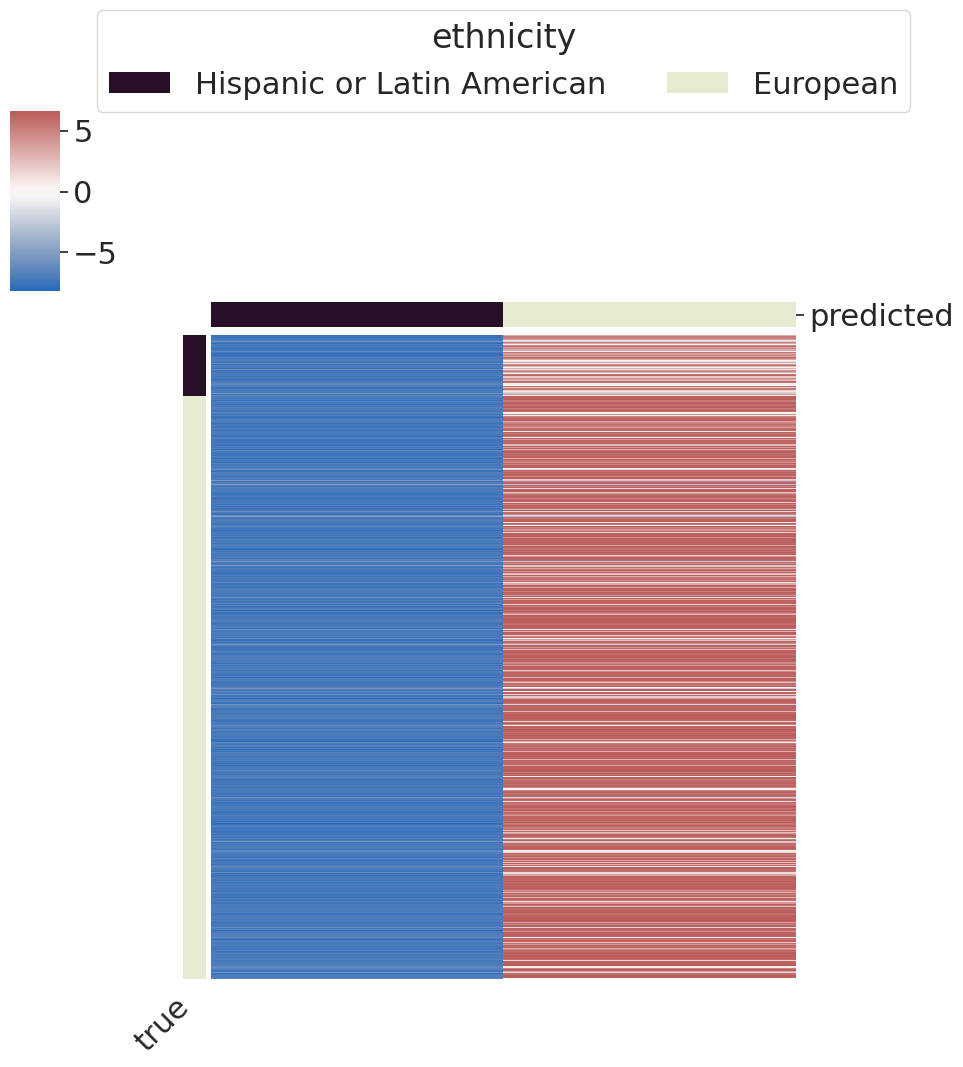

In [21]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    title="ethnicity",
    output_directory=output_dir,
    output_prefix=output_prefix,
    custom_class_order=["Hispanic or Latin American", "European"],
)
